In [1]:
#Plot a set of box plots across all sessions for the velocity, and the position offset at the same time
from scripts.tools.ground_truth_toml_reader import GroundTruth
from scripts.tools.animal_dataframe import AnimalDataFrame
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scripts.tools.estimate_ground_plane import GroundPlaneEstimation
from src.collision import CollisionDetector
from src.animal import AnimalList, AnimalStruct


data_folder = Path("/Users/persie/PhD_Code/3d_ant_data_rle/")
session_list = [6,10,11,13,17,19,20,21,22,23,28,29,30]
obj_ref_frame = [500,180,380,849,459, 59, 842, 24, 93, 176, 2626, 595, 241 ]
prefix = "240905-1616"
skeleton_toml_path = "../skeleton.toml"

node_of_interest = ['a_L2', 'a_R2']

data_out = {}

list_of_animal_struct = []
nested_list_of_animal_list = []
#For each ant in the sample
for experiment_i, session in enumerate(session_list):
    animal_pkl = data_folder / prefix / "outputs" / "tracking" / f"linked_tracks_session{session}.pkl"

    animal_list = AnimalList(toml_path=skeleton_toml_path, pose_pkl=animal_pkl)
    for animal in animal_list.animals:
        list_of_animal_struct.append(animal)
    nested_list_of_animal_list.append(animal_list)

#Get the Ground Plane from all animals
full_animal_list = AnimalList(list_of_animal_struct)

# Estimate the ground plane for this experiment
g = GroundPlaneEstimation(full_animal_list,
                          node_list=['leg_m_L2', 'leg_m_R2', 'leg_f_L2',
                                     'leg_f_R2'], use_precalc=True)
## Now with the ground plane then use the animal lists still separated for collision

##############################
window_size = range(-10, 11)

offset_list = []

In [2]:
g.visualise_bounding_box()

In [2]:

for experiment_i, session in enumerate(session_list):

    animallist_session = nested_list_of_animal_list[experiment_i]

    c = CollisionDetector(animal_list=animallist_session,
                          obj_list=[g.get_ground_collision()],
                          node_of_interest=node_of_interest)


    offset_array = np.full((c.n_collision, len(window_size)), np.nan)
    collision_counter = 0


    collision_tracks = c.get_tracks_in_collision()

    #Find all the tracks that are in the collisions
    for track in collision_tracks:

        local_collision_df = c.get_track(track)
        local_collision_frames = local_collision_df.index.unique().values

        animal = animallist_session.animal(track)
        adf = AnimalDataFrame(animal, None, node_of_interest, signed=True)

        velocity_df = adf.velocity_mag(clean=False)


        #Find the accelerations of the node in the limb
        for frame in local_collision_frames:
            for offset in window_size:
                if velocity_df.keys().__contains__(frame + offset):
                    for node in node_of_interest:
                        if node in local_collision_df.loc[frame].Limb:
                            #add acceleration at these frames to a big dataframe
                            if not np.isnan(velocity_df[frame + offset][node]):
                                offset_array[collision_counter, int((len(window_size)/2)+offset)] = np.array(velocity_df[frame + offset][node])
            collision_counter += 1

    offset_list.append(offset_array)

/Users/persie/PycharmProjects/3d_ant_analysis/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/persie/PycharmProjects/3d_ant_analysis/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/persie/PycharmProjects/3d_ant_analysis/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/persie/PycharmProjects/3d_ant_analysis/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/persie/PycharmProjects/3d_ant_analysis/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty sli

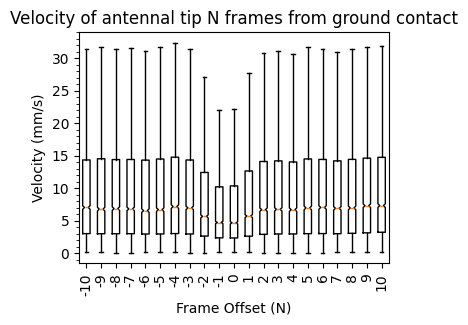

In [12]:
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

offset_array_full = np.vstack(offset_list)

list_of_data = []
for col in offset_array_full.T:
    list_of_data.append(col[np.isfinite(col)])

fig, ax = plt.subplots(figsize=(4, 3))
ax.boxplot(list_of_data, positions=window_size, autorange=False, notch=True, showfliers=False)

plt.title("Velocity of antennal tip N frames from ground contact")
plt.xlabel("Frame Offset (N)")
plt.ylabel("Velocity (mm/s)")
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xticks(window_size, window_size,
              rotation='vertical')

plt.savefig("/Users/persie/Library/CloudStorage/OneDrive-UniversityofEdinburgh/PhD/Figures/Thesis Figures/Experiment Analysis/collision_ground_velocity.svg")
plt.show()